Define Neal's Funnel where $p(x,y) = N(y|0,3) N(x|0,\exp(y/2))$.

In [58]:
from beanmachine.ppl.experimental.tests.vi.neals_funnel import NealsFunnel
nf = NealsFunnel()

Visualize the PDF of Neal's funnel on a grid

In [ ]:
import torch

import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = nf.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Draw some samples from Neal's funnel and plot a KDE

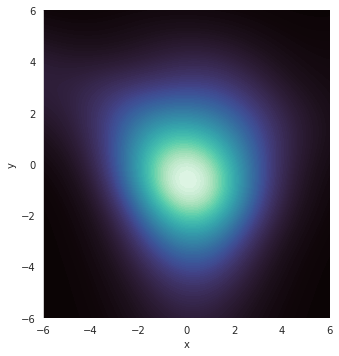

In [42]:
nf_samples = nf.sample(sample_shape=(100,2)).squeeze().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

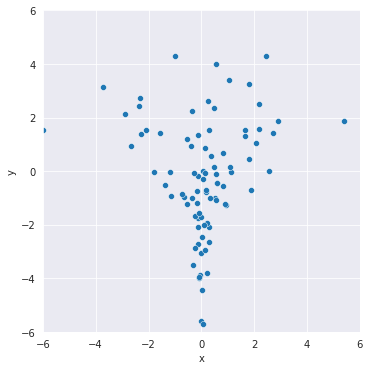

In [43]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": nf_samples[:,0],
        "y": nf_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

Try to perform VI using a neural network transform in a reparameterization trick

In [51]:
from beanmachine.ppl.experimental.vi.VariationalInfer import VariationalInfer

vi = VariationalApproximation(target=nf)
vi.train(epochs=1000)

3.452763557434082
0.7832693457603455
0.4842666685581207
0.49029815196990967
0.31305235624313354
0.4605700671672821
0.37638580799102783
0.4541400074958801
0.3721603453159332
0.4639355540275574


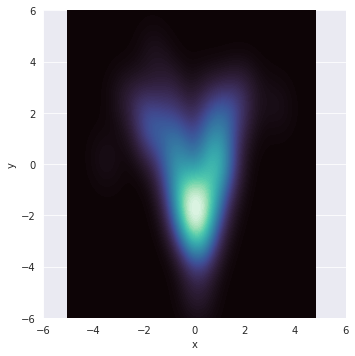

In [52]:
vi_samples = vi.sample((100,2)).detach().numpy()
g = sns.displot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
    kind="kde",
    fill=True, thresh=0, levels=100, cmap="mako",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

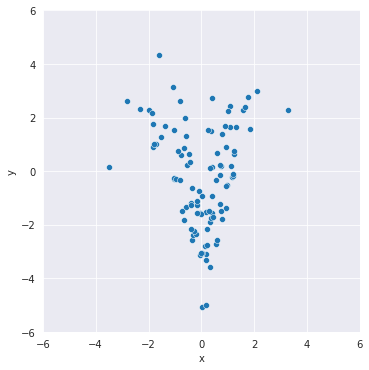

In [53]:
g = sns.relplot(
    data=pd.DataFrame({
        "x": vi_samples[:,0],
        "y": vi_samples[:,1],
    }),
    x="x",
    y="y",
)
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

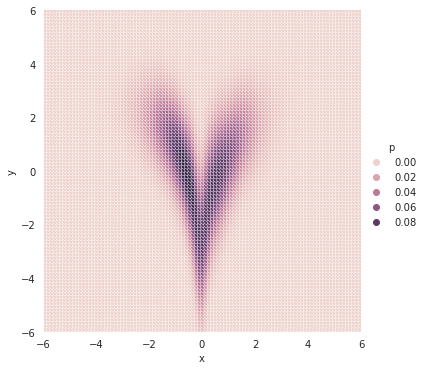

In [54]:
xs = torch.linspace(-6,6)
ys = torch.linspace(-6,6)
XX, YY = torch.meshgrid(xs, ys)
ZZ = torch.stack([XX.flatten(), YY.flatten()]).T
probs = vi.log_prob(ZZ)

g = sns.relplot(data=pd.DataFrame({
    "x": XX.flatten().numpy(),
    "y": YY.flatten().numpy(),
    "p": torch.exp(probs).detach().numpy(),
}), x="x", y="y", hue="p")
g.set(
    xlim=[-6,6],
    ylim=[-6,6],
)

In [57]:
import scipy.stats

scipy.stats.ks_2samp(nf_samples[:,1], vi_samples[:,1]).pvalue

0.1548386665118475

In [56]:
scipy.stats.ks_2samp(nf_samples[:,0], vi_samples[:,0])

Ks_2sampResult(statistic=0.15, pvalue=0.21117008625127576)